In [ ]:
import numpy as np
import scipy
from scipy.io import wavfile
from scipy import fft
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
samplerate, data = wavfile.read('./signal.wav')
print(data.mean())
print(data.dtype)
print(samplerate)

11756.525786302582
int32
16000


In [ ]:
data.shape

(18091,)

16000 frames per second = 16 frame per millisecond

In [ ]:
# Mean Subtraction
data = data - data.mean()
print(data.mean())

1.8252707537209887e-09


In [ ]:
# Pre-emphasis filtering
coef = 0.97
x3 = np.zeros_like(data)
x3[0] = data[0]
for n in range(1, len(data)):
    x3[n] = data[n] - coef * data[n-1]

In [ ]:
x3

array([ 162818.4742137 ,  279946.55422641, -120352.58577359, ...,
       -137258.38577359, -149305.20577359,   20760.82422641])

In [ ]:
# computing frames
frames = []
L = 25 * 16
S = 10 * 16
for k in range((len(x3) - L + 1) // S + 2):
    if k != (len(x3) - L) // S + 1:
        frames.append(x3[k*S: (k*S + L)])
    else:
        temp = np.zeros(L)
        temp[:len(x3) - k*S] = x3[k*S:]
        frames.append(temp)
frames = np.array(frames)
print(frames.shape)

(112, 400)


(23, 257)


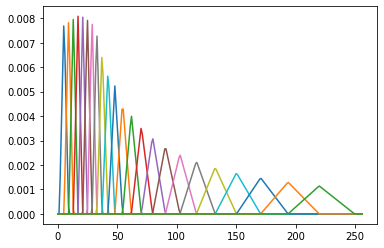

In [ ]:
#  Mel-filterbank visualization
mel_filters = np.load('mel_filters.npy')
print(mel_filters.shape)
plt.plot(mel_filters.T)
plt.show()

In [ ]:

def pipeline(frames, L):
    total_X_logmel_before_max = []
    total_X_logmel = []
    total_c = []
    # for each frame
    for frame in frames:

        # applying the window function
        frame = signal.hamming(L) * frame

        # Computing the Fourier transform
        frame = fft.fft(frame, 512)

        # Computing the magnitude and power spectra
        mag = np.abs(frame)
        pow = mag * mag

        # store  𝑚𝑎𝑥(−50,log(𝑋𝑝𝑜𝑤[𝑚]))
        logpow = np.log(pow)
        logpow[logpow < -50] = -50
        total_X_logmel_before_max.append(logpow)

        # Mel-filterbank application
        X_mel = np.sum(mel_filters * pow[:257], axis = 1)

        # Taking the log
        X_logmel = np.log(X_mel)
        X_logmel[X_logmel < -50] = -50
        total_X_logmel.append(X_logmel)
        
        # Computing the DCT and “liftering”
        C = [sum([X_logmel[k] * np.cos(np.pi * i / 23 * (k + 0.5)) for k in range(23)]) for i in range(13)]
        total_c.append(C)

    total_c = np.array(total_c)
    total_X_logmel = np.array(total_X_logmel)
    total_X_logmel_before_max = np.array(total_X_logmel_before_max)
    return total_c, total_X_logmel, total_X_logmel_before_max

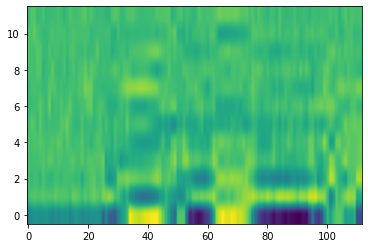

In [ ]:
total_c, total_X_logmel, total_X_no_mel = pipeline(frames, L)
plt.imshow(total_c[:, 1:].T, origin='lower', aspect='auto')

(112, 13)


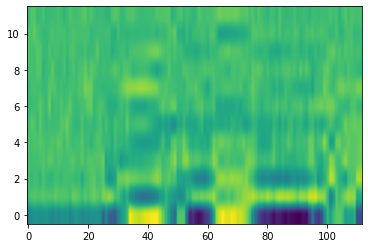

In [ ]:
ref = np.load('reference_mfcc.npy')
print(ref.shape)
plt.imshow(ref[:, 1:].T, origin='lower', aspect='auto')

In [ ]:
# compute the mse
mse = (np.square(total_c - ref)).mean()
print(f'MSE error = {mse}')

MSE error = 2.0986627966469446e-26


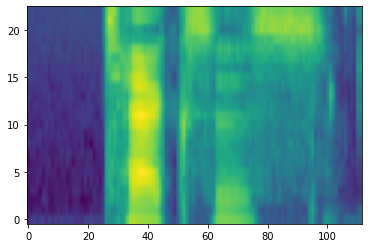

In [ ]:
# plot the MFSCs 𝑋𝑙𝑜𝑔𝑚𝑒𝑙 for the entire utterance
plt.imshow(total_X_logmel.T, origin='lower', aspect='auto')

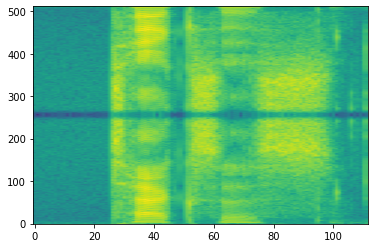

In [ ]:

plt.imshow(total_X_no_mel.T, origin='lower', aspect='auto')

(1128, 64)


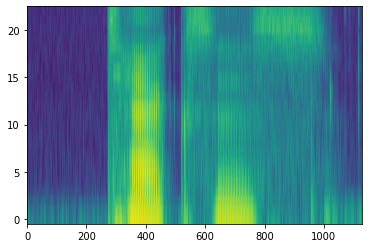

In [ ]:
# change frame and do it again
frames = []
L = 4 * 16
S = 1 * 16
for k in range((len(data) - L) // S + 2):
    if k != (len(data) - L) // S + 1:
        frames.append(data[k*S: (k*S + L)])
    else:
        temp = np.zeros(L)
        temp[:len(data) - k*S] = data[k*S:]
        frames.append(temp)
frames = np.array(frames)
print(frames.shape)
total_c_2, total_X_logmel_2, total_2_before = pipeline(frames, L)

plt.imshow(total_X_logmel_2.T, origin='lower', aspect='auto')



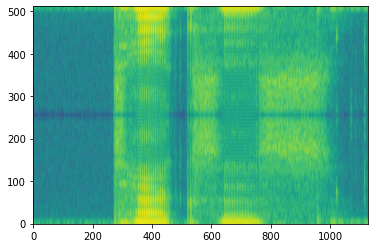

In [ ]:

plt.imshow(total_2_before.T, origin='lower', aspect='auto')

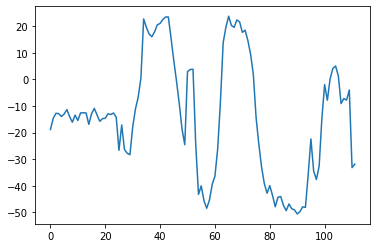

In [ ]:
plt.plot(total_c[:, 1])

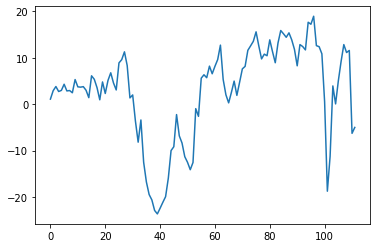

In [ ]:
plt.plot(total_c[:, 2])

In [ ]:
total_X_logmel.shape

(112, 23)

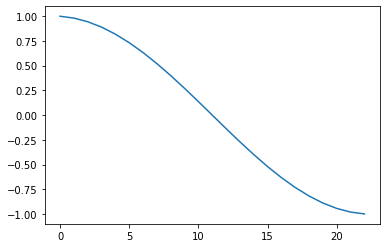

In [ ]:
# plot the cos term in the DCT function when i = 1
test = [np.cos(np.pi * 1 / 23 * (k + 0.5)) for k in range(23)]
plt.plot(test)

(23, 257)


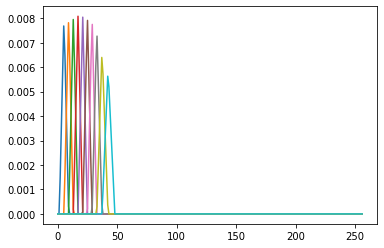

In [ ]:
#  Mel-filterbank with only positive effect when i = 1
mel_filters = np.load('mel_filters.npy')
print(mel_filters.shape)
plt.plot(mel_filters.T[:, :10])
plt.show()

In [ ]:
mel_filters.shape

(23, 257)